(log-reg-notebook)=
# Modello di regressione logistica

In questo capitolo, approfondiremo la regressione logistica bivariata, una metodologia statistica che ci consente di analizzare le relazioni tra una variabile di risultato binaria e una singola variabile indipendente. Esploreremo il processo di stima dei coefficienti del modello attraverso un approccio bayesiano, il quale ci offre stime a posteriori più informative e la possibilità di calcolare intervalli di credibilità per tali coefficienti. In aggiunta, forniremo un'interpretazione dei risultati ottenuti dalla regressione logistica. Mostreremo come i coefficienti influenzano la probabilità di successo della variabile binaria di risultato, nonché come interpretare il loro segno e ampiezza. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import bambi as bmb
from sklearn.metrics import confusion_matrix
from scipy.special import expit
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Regressione logistica

La regressione logistica viene utilizzata nel trattamento di variabili dipendenti binarie, che possono assumere solamente due esiti possibili, comunemente etichettati come "successo" (1) o "fallimento" (0). Prendiamo, per esempio, una ricerca incentrata sulla propensione di una persona a praticare jogging; l'outcome sarà o 0 (non ha fatto jogging) o 1 (ha fatto jogging oggi).

Tali dati possono anche essere espressi in termini di proporzioni, come nella domanda "Quanti giorni hai fatto jogging negli ultimi 7 giorni?". In tale contesto, parliamo di regressione binomiale. Tuttavia, l'utilizzo di proporzioni può causare la perdita di dettagli informativi. Ad esempio, una proporzione di 0.5 potrebbe essere generata da diverse combinazioni di successi e fallimenti (come 1 su 2 o 2 su 4), e tali dettagli vanno persi se usiamo solo la proporzione. Quindi, è preferibile lavorare con dati grezzi, ovvero con l'intera sequenza di 0 e 1, quando possibile.

Dal punto di vista della statistica Bayesiana, la regressione logistica è strutturata in modo che ogni suo elemento, compresi i coefficienti di regressione, sia considerato come una variabile casuale. L'obiettivo principale diventa l'identificazione della distribuzione a posteriori dei coefficienti di regressione, calcolata mediante la formula Bayesiana:

$$
p(\theta \mid y) = \frac{p(y \mid \theta) p(\theta)}{p(y)}.
$$

Calcolare il denominatore di questa formula è notoriamente complicato, ma l'uso di metodi di campionamento MCMC ci permette di eludere tale problematica, focalizzando l'attenzione solo sul numeratore. A questo scopo, è necessario specificare due elementi: la distribuzione a priori $ p(\theta) $ e la funzione di verosimiglianza $ p(y \mid \theta) $. Generalmente, si opta per una distribuzione a priori debolmente informativa, in modo da lasciare che i dati influenzino significativamente le stime a posteriori, riducendo l'effetto di assunzioni soggettive o arbitrarie.

La funzione di verosimiglianza in una regressione logistica è rappresentata dal prodotto di $ n $ prove di Bernoulli, ciascuna delle quali è descritta da:

$$
p_i^{y_i} (1-p_i)^{1-y_i},
$$

dove $p_i = P(y_i = 1)$ è la probabilità di successo in una singola prova Bernoulliana e $ y_i $ è l'effettivo esito (0 o 1).

Per specificare $ p_i $, una delle opzioni più comuni è ricorrere alla funzione link logistica, definita come segue:

$$
p_i = \frac{1}{1 + e^{-\eta_i}},
$$

dove $ \eta_i $ è calcolato come una combinazione lineare dei predittori $ X $ e dei coefficienti di regressione $ \theta $:

$$
\eta_i = \theta_0 + \theta_1 X_{i}.
$$

In questa formulazione, $ \theta_0 $ è l'intercetta e $ \theta_1 $ è il coefficiente del predittore $ X_i $. La funzione logit mappa quindi il valore di $ \eta_i $, che può variare da $ -\infty$ a $ \infty $, in una probabilità $ p_i $ compresa tra 0 e 1.

In definitiva, la regressione logistica è una specializzazione della regressione lineare, focalizzata sulla modellazione delle probabilità condizionate di una variabile Bernoulliana $ Y $. Utilizza la funzione logistica come funzione link per convertire relazioni lineari nei predittori ($\eta_i = \theta_0 + \theta_1 X_{i}$) in probabilità comprese tra 0 e 1. Di conseguenza, anziché modellare direttamente la probabilità $ \pi $, modelliamo una funzione di questa probabilità attraverso un modello lineare, utilizzando la funzione logit come funzione di collegamento.

### Coefficienti del modello e logit

Nella regressione logistica, i coefficienti dei predittori sono espressi come logaritmi dell'odds ratio. Questa rappresentazione lineare dei coefficienti semplifica la modellazione e l'interpretazione dei risultati.

Ad esempio, supponiamo di avere un modello di regressione logistica con un singolo predittore binario $X$, e il coefficiente stimato per $X$ è $\beta_1 = 0.50$. Questo significa che il logaritmo dell'odds ratio per $X$ è $\log(OR) = 0.50$. Per interpretare questo valore, dobbiamo esponenziarlo:

$$ OR = e^{0.50} \approx 1.65. $$

Questo ci dice che la probabilità dell'evento di interesse nel gruppo con $X = 1$ è circa 1.65 volte più grande rispetto al gruppo con $X = 0$. Se il valore del logaritmo dell'odds ratio fosse stato negativo, avremmo concluso che l'odds dell'evento nel gruppo con $X = 1$ è più piccolo rispetto al gruppo con $X = 0$.


```{note}
Esaminiamo nei dettagli la relazione tra la funzione logistica e i log-odds. Partendo dalla funzione logistica per $ p_i $, che è:

$$
p_i = \frac{1}{1 + e^{-\eta_i}}
$$

possiamo riformulare questa espressione per isolare $ e^{-\eta_i} $ in termini di $ p_i $:

$$
1 + e^{-\eta_i} = \frac{1}{p_i}
$$

$$
e^{-\eta_i} = \frac{1}{p_i} - 1
$$

$$
e^{-\eta_i} = \frac{1 - p_i}{p_i}
$$

Ora, prendiamo il reciproco di entrambi i lati dell'equazione:

$$
\frac{1}{e^{-\eta_i}} = \frac{p_i}{1 - p_i}
$$

$$
e^{\eta_i} = \frac{p_i}{1 - p_i}
$$

Infine, applichiamo il logaritmo naturale ad entrambi i lati per ottenere $ \eta_i $:

$$
\ln(e^{\eta_i}) = \ln\left(\frac{p_i}{1 - p_i}\right)
$$

$$
\eta_i = \ln\left(\frac{p_i}{1 - p_i}\right)
$$

In questo modo abbiamo dimostrato che 

$$ 
\eta_i = \ln\left(\frac{p_i}{1 - p_i}\right) = \theta_0 + \theta_1 X_{i},
$$ 

che è una combinazione lineare del predittore $X$, è effettivamente il logaritmo del rapporto delle probabilità, o il log-odds. Questa è la connessione fondamentale tra la funzione logistica e il log-odds in un modello di regressione logistica.
```



## Un esempio concreto

Esaminiamo ora come eseguire la regressione logistica con PyMC. 

## American National Election Studies (ANES)

In questo tutorial, utilizzeremo un set di dati forniti dal sito di Bambi per illustrare il modello di regressione logistica. Questi dati provengono dallo studio pilota del 2016. Lo studio completo includeva 1200 persone, ma in questo caso, è stato selezionato un sottoinsieme di 487 persone che hanno risposto a una domanda riguardante se avrebbero votato per Hillary Clinton o Donald Trump.

Importiamo i dati.

In [3]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


La nostra variabile di esito è `vote`, che indica le risposte delle persone alla seguente domanda:

> If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?

Esaminiamo la distribuzione di frequenze della variabile `vote`.

In [4]:
data["vote"].value_counts()

vote
clinton         215
trump           158
someone_else     48
Name: count, dtype: int64

Per semplificare l'analisi, qui considereremo solo le risposte `Clinton` e `Trump`. 

In [5]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


## Specificare e adattare il modello in Bambi

Nel nostro esempio, miriamo a modellare la probabilità di voto per Clinton in funzione dell'età. L'obiettivo è quindi di utilizzare la regressione logistica per rappresentare $ \pi = P(Y = 1) $, cioè la probabilità di votare per Clinton, con l'età come variabile esplicativa.

La regressione logistica collega il logit di $ \pi $ a un predittore o a una combinazione lineare di predittori. Pertanto, l'equazione matematica del nostro modello sarà la seguente:

$$
\log\left(\frac{\pi}{1 - \pi}\right) = \beta_0 + \beta_1 X,
$$

dove $ X $ rappresenta l'età.

Per applicare l'approccio bayesiano, dobbiamo specificare una distribuzione a priori per i parametri e una funzione di verosimiglianza. Nella nostra analisi, useremo le distribuzioni a priori predefinite offerte da Bambi, e la funzione di verosimiglianza sarà il prodotto delle prove Bernoulliane, ovvero:

$$
\prod_{i=1}^{n}{p_i^{y_i}(1-p_i)^{1-y_i}},
$$

dove $ p_i = P(Y=1) $ e $ y_i = 1 $ se l'intenzione di voto è per Clinton, mentre $ y_i = 0 $ se è per Trump.

La specificazione del modello è resa intuitiva dalla sintassi richiesta da Bambi: basta formulare il modello seguendo la sintassi delle formule di Wilkinson {cite:p}`wilkinson1973symbolic` e fornire il corretto argomento per `family`. Vale la pena notare l'uso di una sintassi opzionale sul lato sinistro della formula: `vote[clinton]` indica a Bambi che intendiamo modellare la probabilità che `vote` sia uguale a `clinton`, piuttosto che a `trump`.

Sul lato destro della formula, utilizziamo il termine `age` per segnalare a Bambi la nostra intenzione di includere la variabile esplicativa `age` nel modello.

In [6]:
clinton_model = bmb.Model("vote['clinton'] ~ age", clinton_data, family="bernoulli")

Procediamo ora con il campionamento. L'argomento opzionale `idata_kwargs={"log_likelihood": True}` richiede il calcolo del logaritmo della verosimiglianza (log-likelihood) durante l'adattamento. Questo passaggio è rischiesto per potere utilizzare in seguito varie funzioni che valutano quanto bene il modello si adatta ai dati.

In [7]:
clinton_fitted = clinton_model.fit(
    method="nuts_numpyro", idata_kwargs={"log_likelihood": True}
)

Modeling the probability that vote==clinton


Compiling...
Compilation time =  0:00:10.833725
Sampling...


Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]








Running chain 3: 100%|██████████| 2000/2000 [00:01<00:00, 1260.55it/s]


Sampling time =  0:00:01.887441
Transforming variables...
Transformation time =  0:00:00.004097
Computing Log Likelihood...
Log Likelihood time =  0:00:00.419094


Possiamo stampare l'oggetto `clinton_model` per visualizzare informazioni sulla distribuzione della risposta, la funzione link e le distribuzioni a priori.

In [13]:
clinton_model

       Formula: vote['clinton'] ~ age
        Family: bernoulli
          Link: p = logit
  Observations: 373
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 7.586)
            age ~ Normal(mu: 0.0, sigma: 0.1454)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Otteniamo una rappresentazione delle distribuzioni a priori usate da Bambi.

Sampling: [Intercept, age]


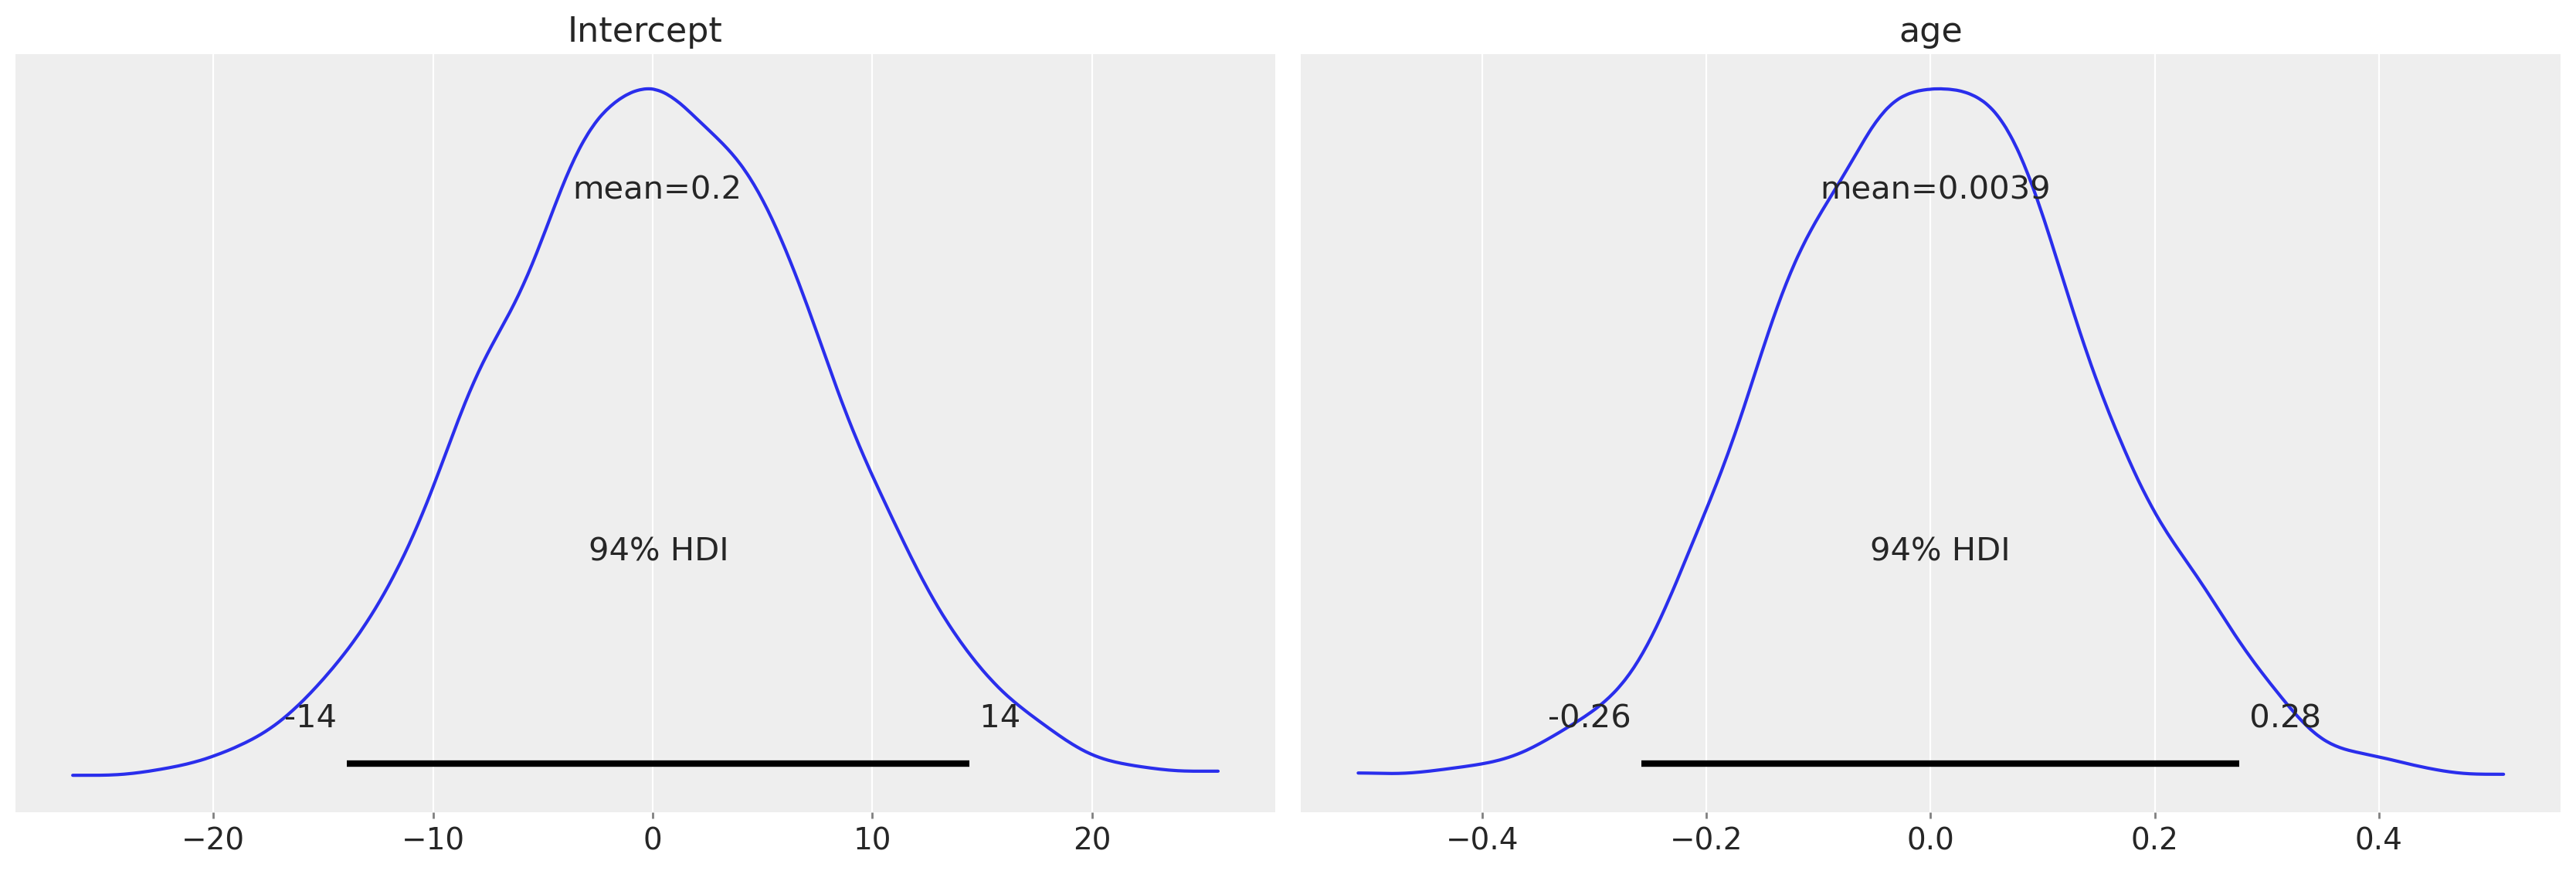

In [8]:
clinton_model.plot_priors()
plt.show()

## Valutazione del modello

Esaminiamo i trace plot delle distribuzioni a posteriori dei parametri.

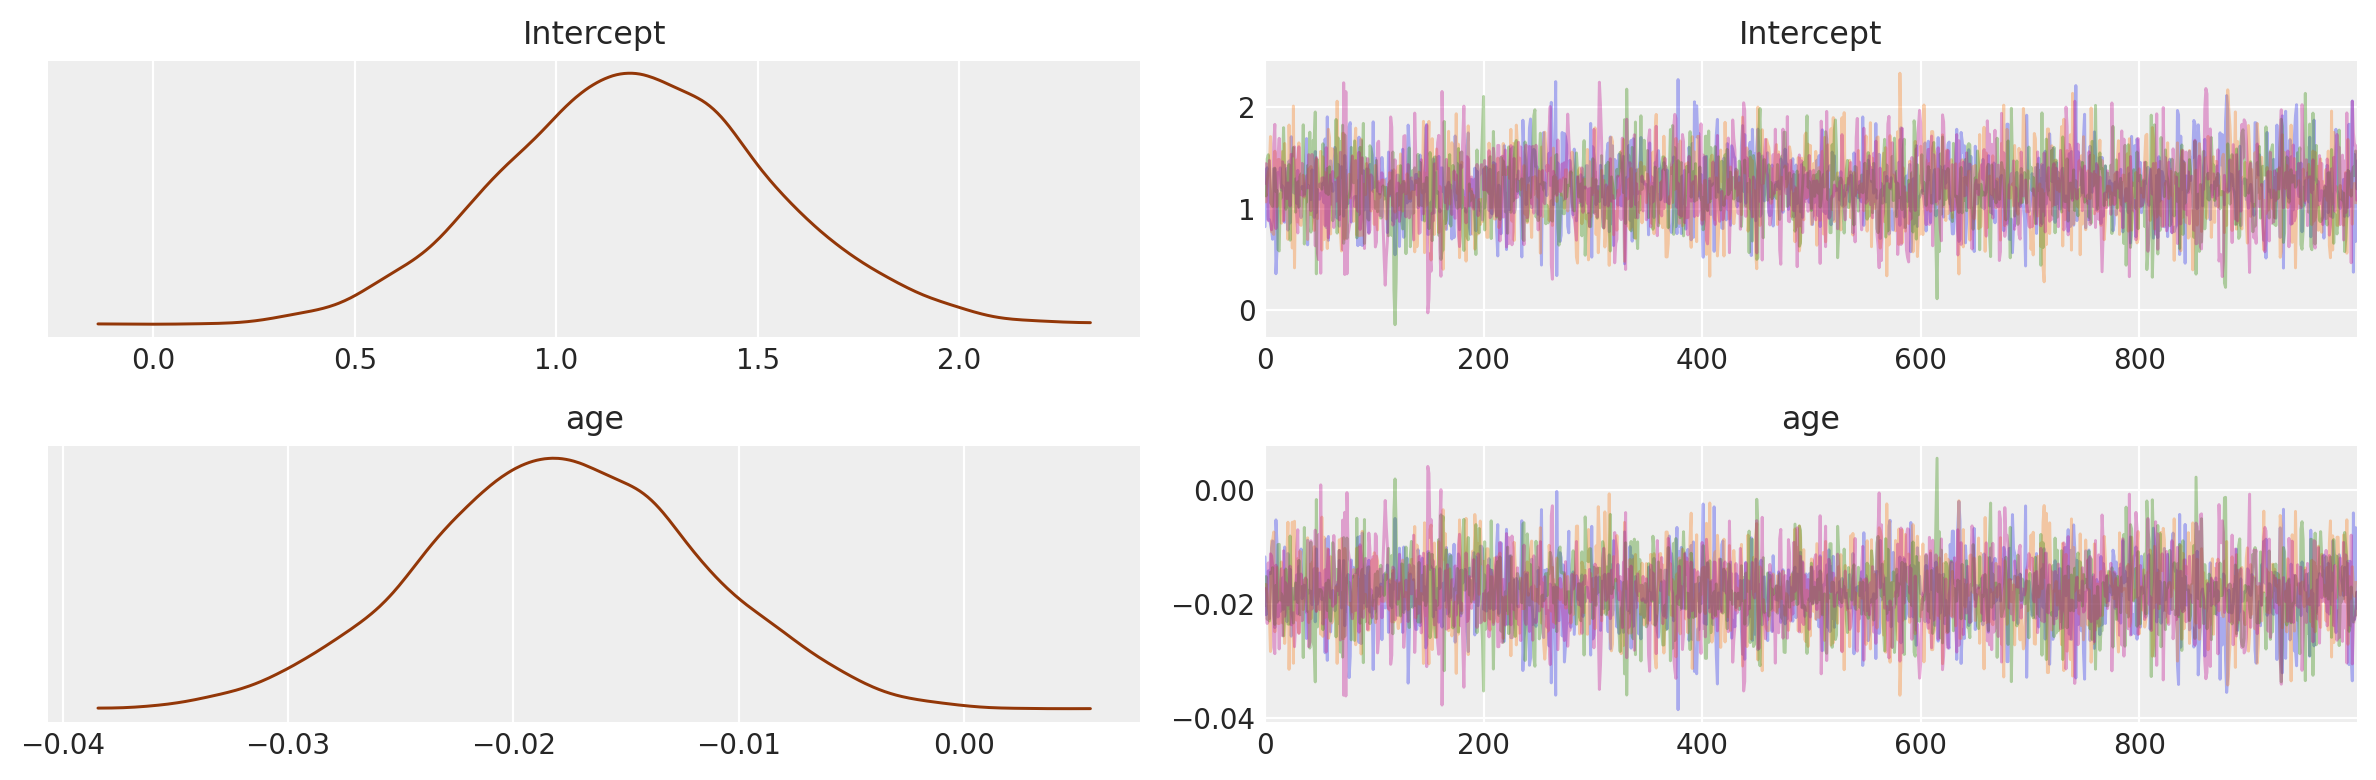

In [9]:
az.plot_trace(clinton_fitted, combined=True, compact=False)
plt.tight_layout()
plt.show()

### Posterior Predictive Check

Generiamo le previsioni posteriori dal modello di regressione logistica bivariata adattato ai dati di voto per Clinton. Il parametro `clinton_fitted` rappresenta l'output dell'adattamento del modello, che contiene le stime posteriori dei parametri del modello. Il parametro `kind="pps"` indica il tipo di previsione che vogliamo ottenere, nel caso specifico "pps" sta per "posterior predictive samples" (campioni predittivi posteriori). Questo significa che stiamo generando campioni casuali da una distribuzione predittiva basata sui parametri stimati e sulle distribuzioni a posteriori. In altre parole, stiamo simulando possibili risultati futuri o predizioni che potrebbero verificarsi dato il modello adattato ai dati.

In [11]:
posterior_predictive = clinton_model.predict(clinton_fitted, kind="pps")

Otteniamo il Posterior Preditive Check.

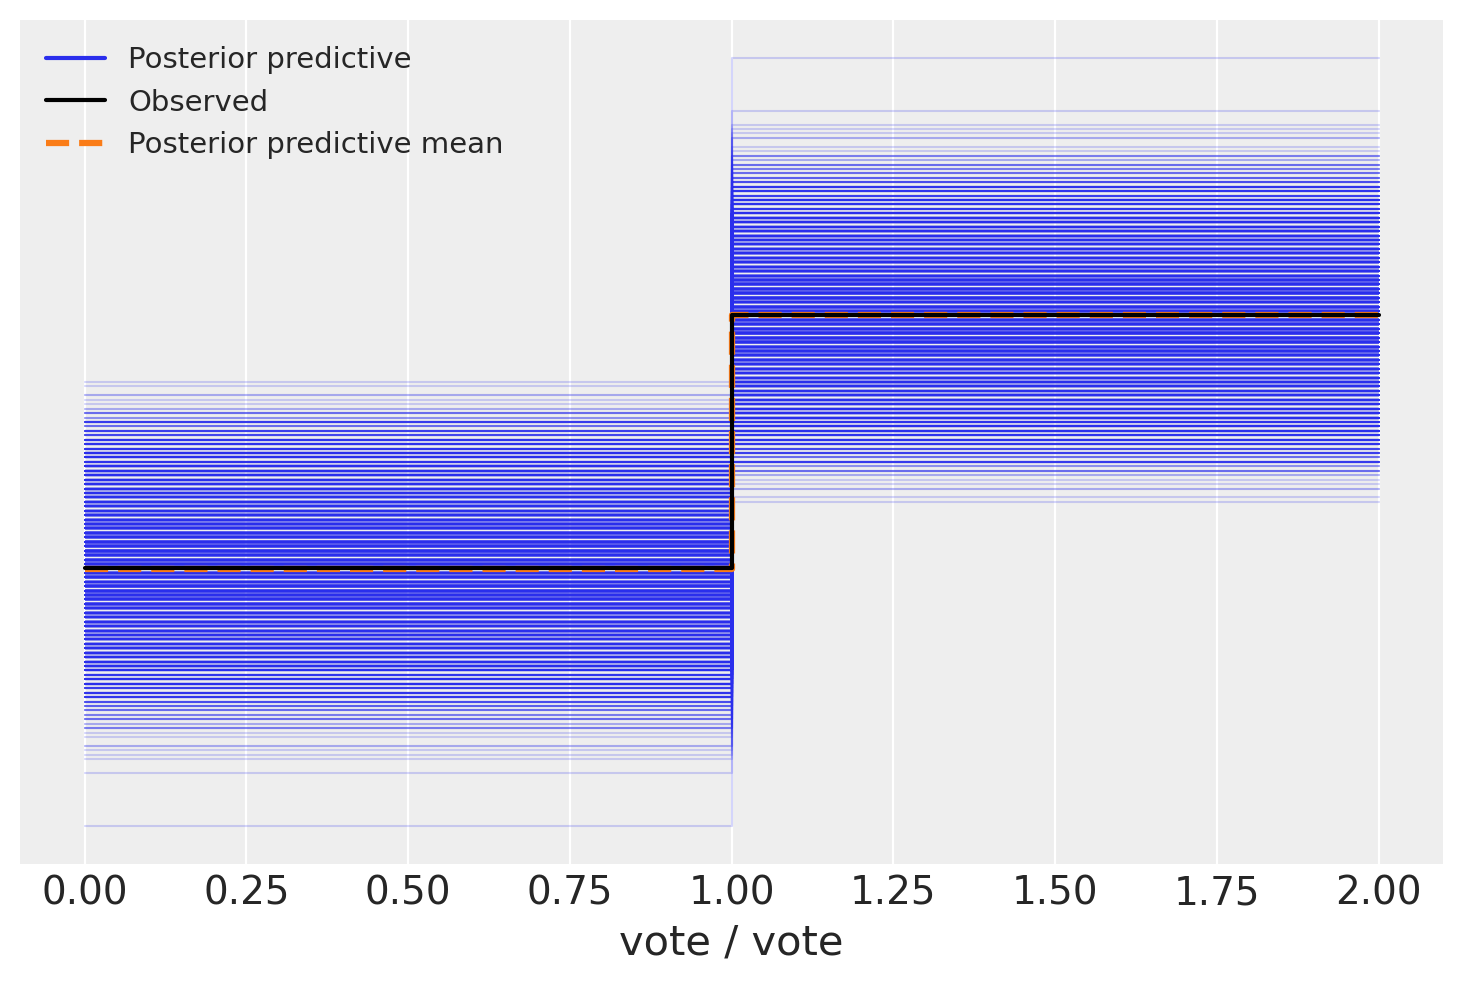

In [12]:
az.plot_ppc(clinton_fitted)
plt.show()

I possibili risultati futuri sono coerenti con i dati osservati, il che fornisce evidenze di un buon adattamento del modello.

## Parametro $\hat \kappa$

Possiamo utilizzare ArviZ per calcolare [LOO](https://arxiv.org/abs/1507.04544) e individuare le osservazioni che hanno un impatto significativo, basandoci sul valore stimato del parametro $\hat \kappa$. 

In [13]:
loo = az.loo(clinton_fitted, pointwise=True)

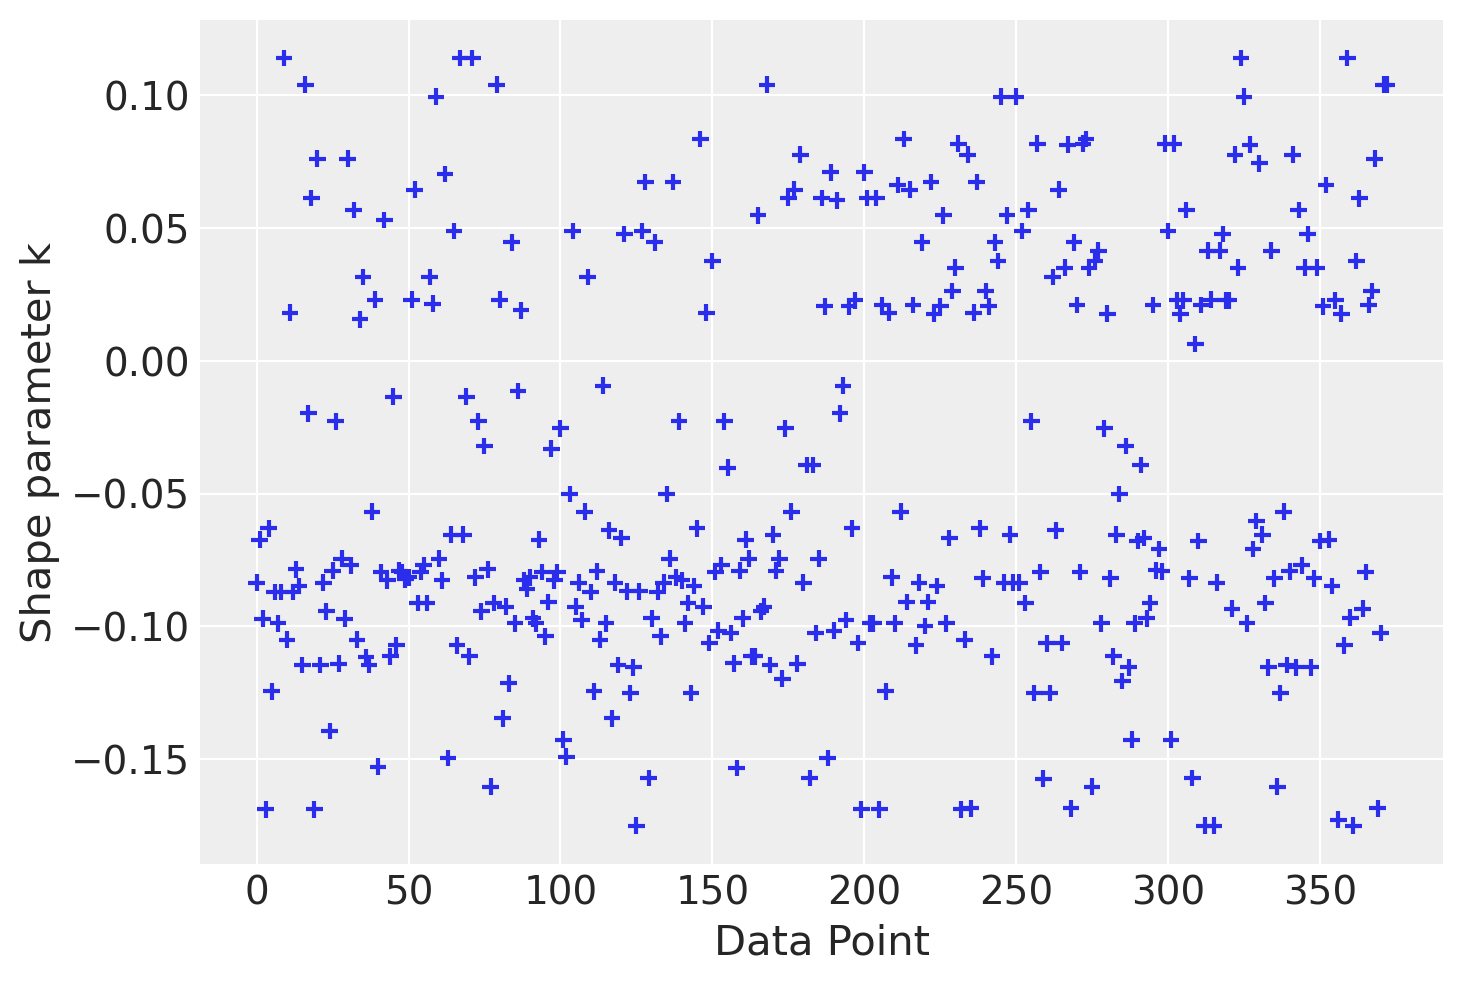

In [14]:
az.plot_khat(loo.pareto_k)
plt.show()

La presenza di valori di $|\hat \kappa| < 0.5$ nel grafico suggerisce un'elevata qualità dell'adattamento del modello, confermata dalla buona mescolanza delle catene MCMC. In questo contesto, non sono rilevabili problemi significativi di convergenza, né si osservano evidenze di punti dati particolarmente influenti. Questo è indicativo di un modello che si adatta efficacemente ai dati a disposizione.

## Inferenza

Esaminiamo una sintesi delle distribuzioni a posteriori dei parametri.

In [15]:
summary_df = az.summary(clinton_fitted)
print(summary_df)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept       1.196  0.332   0.577    1.828      0.006    0.004    3596.0   
age            -0.018  0.006  -0.029   -0.006      0.000    0.000    4214.0   
vote_mean[0]    0.549  0.027   0.498    0.602      0.000    0.000    3204.0   
vote_mean[1]    0.509  0.034   0.438    0.568      0.001    0.000    3973.0   
vote_mean[2]    0.443  0.051   0.355    0.549      0.001    0.001    4348.0   
...               ...    ...     ...      ...        ...      ...       ...   
vote_mean[368]  0.605  0.028   0.555    0.659      0.001    0.000    2911.0   
vote_mean[369]  0.592  0.026   0.545    0.645      0.000    0.000    2871.0   
vote_mean[370]  0.513  0.033   0.451    0.577      0.001    0.000    3883.0   
vote_mean[371]  0.622  0.030   0.569    0.681      0.001    0.000    3018.0   
vote_mean[372]  0.622  0.030   0.569    0.681      0.001    0.000    3018.0   

                ess_tail  r_hat  
Intercept        

### Interpretazione dei coefficienti nella regressione logistica

Sulla base delle distribuzioni a posteriori dei parametri, possiamo scrivere l'equazione del modello di regressione logistica nel modo seguente:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 \cdot \text{età}.
$$

### Interpretazione di $\beta_0$

Quando il predittore $X$ è pari a 0, $\beta_0$ rappresenta il logit dell'evento di interesse (voto per Clinton) e $e^{\beta_0}$ rappresenta gli odds di successo ($\pi / (1-\pi)$).

Nel caso presente, dunque, per un'età pari a 0, gli odds di successo ($\pi / (1-\pi)$) sono pari a

In [16]:
beta_0 = summary_df.loc['Intercept', 'mean']
print(beta_0)

1.196


In [17]:
np.exp(beta_0)

3.306862980601789

e la probabilità di un voto per Clinton è

In [18]:
np.exp(beta_0) / (1 + np.exp(beta_0))

0.76781244156036

Tuttavia, nel caso presente, l'intercetta non fornisce informazioni utili. Se avessimo trasformato i dati codificando l'età come scarti dalla media, le interpretazioni precedenti sarebbero riferite all'età media del campione, il che avrebbe più senso.

### Interpretazione di $\beta_1$

Quando $X$ aumenta di 1, da $x$ a $x+1$, $\beta_1$ rappresenta il cambiamento tipico nel logit, e $e^{\beta_1}$ rappresenta il cambiamento tipico moltiplicativo negli odds:

$$
\beta_1 = \log(\text{odds}_{x+1}) - \log(\text{odds}_x) \quad \text{e} \quad e^{\beta_1} = \frac{\text{odds}_{x+1}}{\text{odds}_x}.
$$

In altre parole, sulla scala lineare dei logit, il coefficiente $\beta_1$ rappresenta semplicemente la pendenza: per un cambiamento unitario dell'età, i logit del voto per Clinton diminuiscono di -0.018. 

Tuttavia, è più facile interpretare questo risultato sulla scala non lineare degli odds, dove questa variazione è moltiplicativa: per ogni anno di aumento dell'età, gli odds stimati dell'evento (votare per Clinton) vengono moltiplicati per $e^{\beta_1}$:

In [19]:
beta_1 = summary_df.loc['age', 'mean']
print(beta_1)

-0.018


In [20]:
np.exp(beta_1)

0.9821610323583008

Poiché la relazione di probabilità è una curva sigmoidale, non possiamo interpretare facilmente il coefficiente $\beta_1$ su questa scala. È invece preferibile rappresentare graficamente come varia la probabilità attesa di "successo" al variare dell'età. La rappresentazione di questa relazione, basata sulle stime a posteriori del modello, è fornita di seguito.

In [21]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3)
})
new_data

,age
0,18
1,19
2,20
3,21
4,22
...,...
214,86
215,87
216,88
217,89


In [22]:
clinton_model.predict(clinton_fitted, data=new_data)

In [23]:
vote_posterior = az.extract(clinton_fitted, num_samples=2000)["vote_mean"]
vote_posterior.shape

(219, 2000)

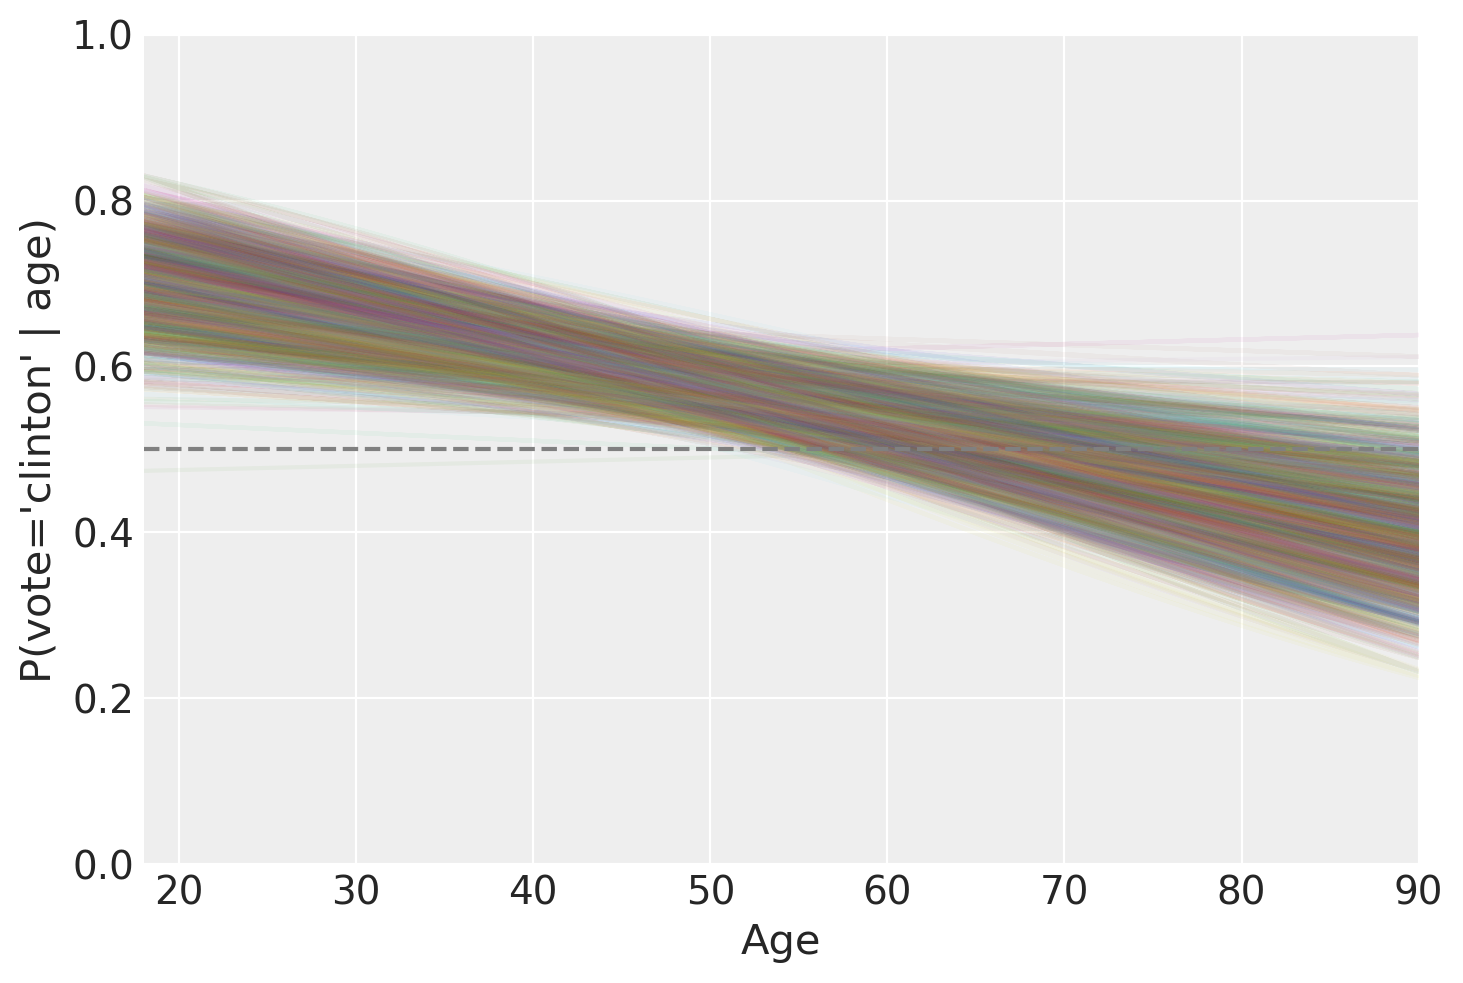

In [24]:
plt.plot(new_data.age, vote_posterior, alpha=0.05)

# Adding a dashed horizontal line at y=0.5 (50% probability)
plt.axhline(y=0.5, color="gray", linestyle="dashed")

plt.ylabel("P(vote='clinton' | age)")
plt.xlabel("Age")
plt.ylim(0, 1)
plt.xlim(18, 90);

È possibile interpretare il grafico precedente nel seguente modo: fino all'età di circa 50 anni, la propensione al voto per Clinton supera quella per Trump. Proseguendo oltre i 50 anni, questa tendenza tende ad invertirsi. La presenza di più curve nel grafico indica l'incertezza a posteriori delle previsioni effettuate dal modello.

Per chiarire i risultati del modello di regressione logistica possiamo mostrare le predizioni del modello in due formati. Nel primo grafico, mostriamo i logit predetti come funzione lineare dell'età.

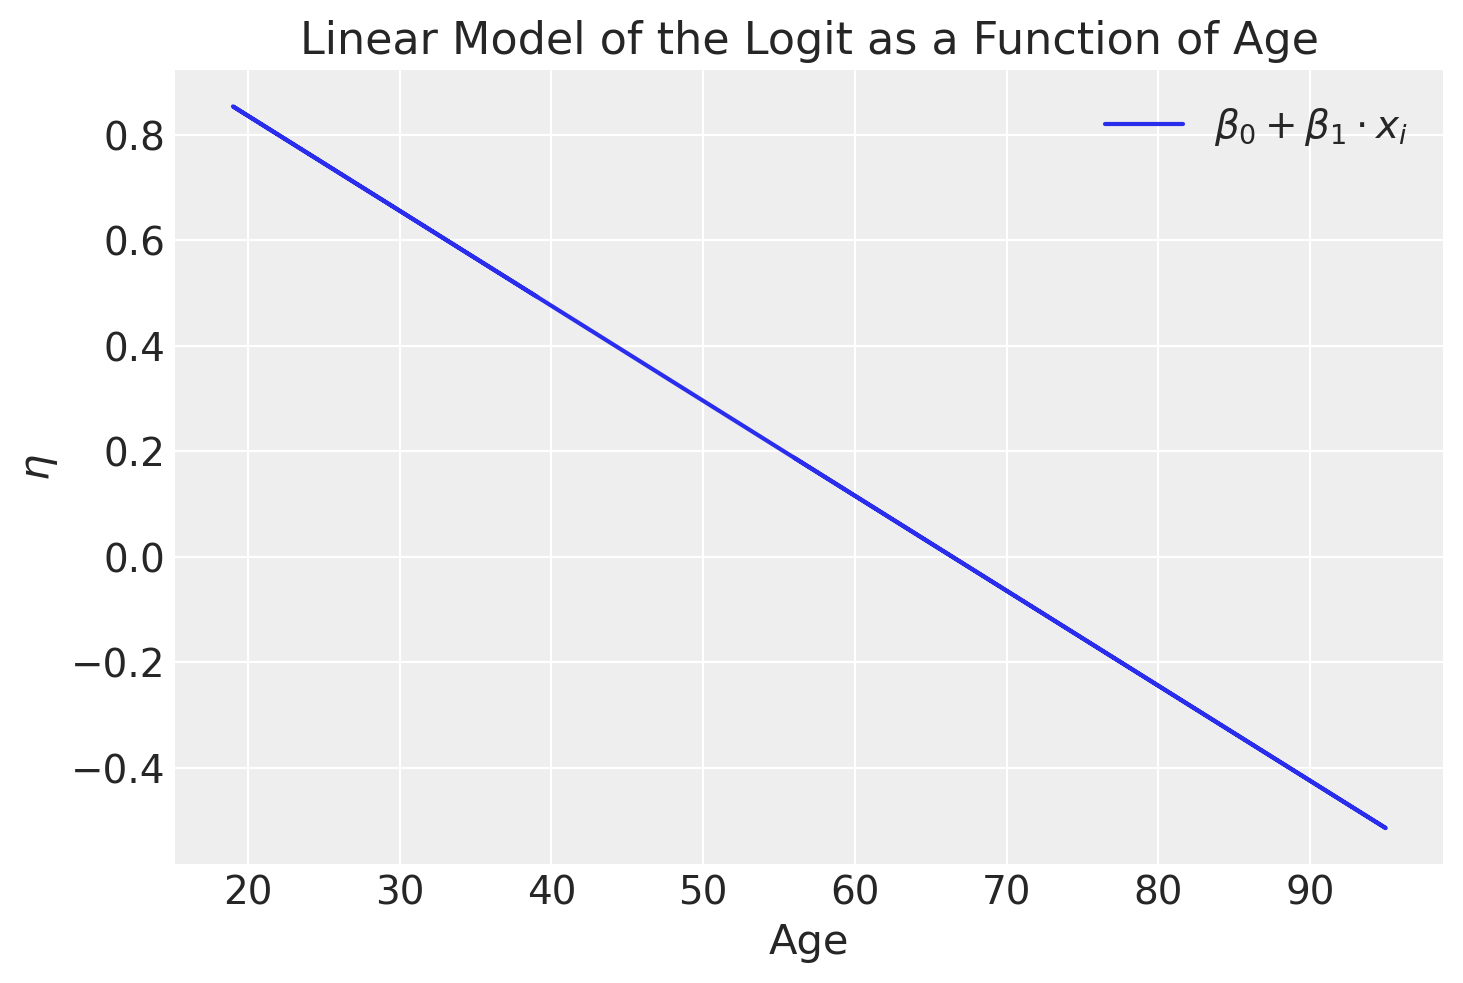

In [25]:
eta = beta_0 + beta_1 * clinton_data["age"]

plt.figure()
plt.plot(clinton_data["age"], eta, label=r"$\beta_0 + \beta_1 \cdot x_i$")
plt.xlabel("Age")  # Label for the x-axis
plt.ylabel(r"$\eta$")  # Label for the y-axis
plt.title("Linear Model of the Logit as a Function of Age")  # Title for the plot
plt.legend()
plt.show()

Nel secondo grafico mostriamo la probabilità di votare per Clinton come funzione non lineare dell'età.

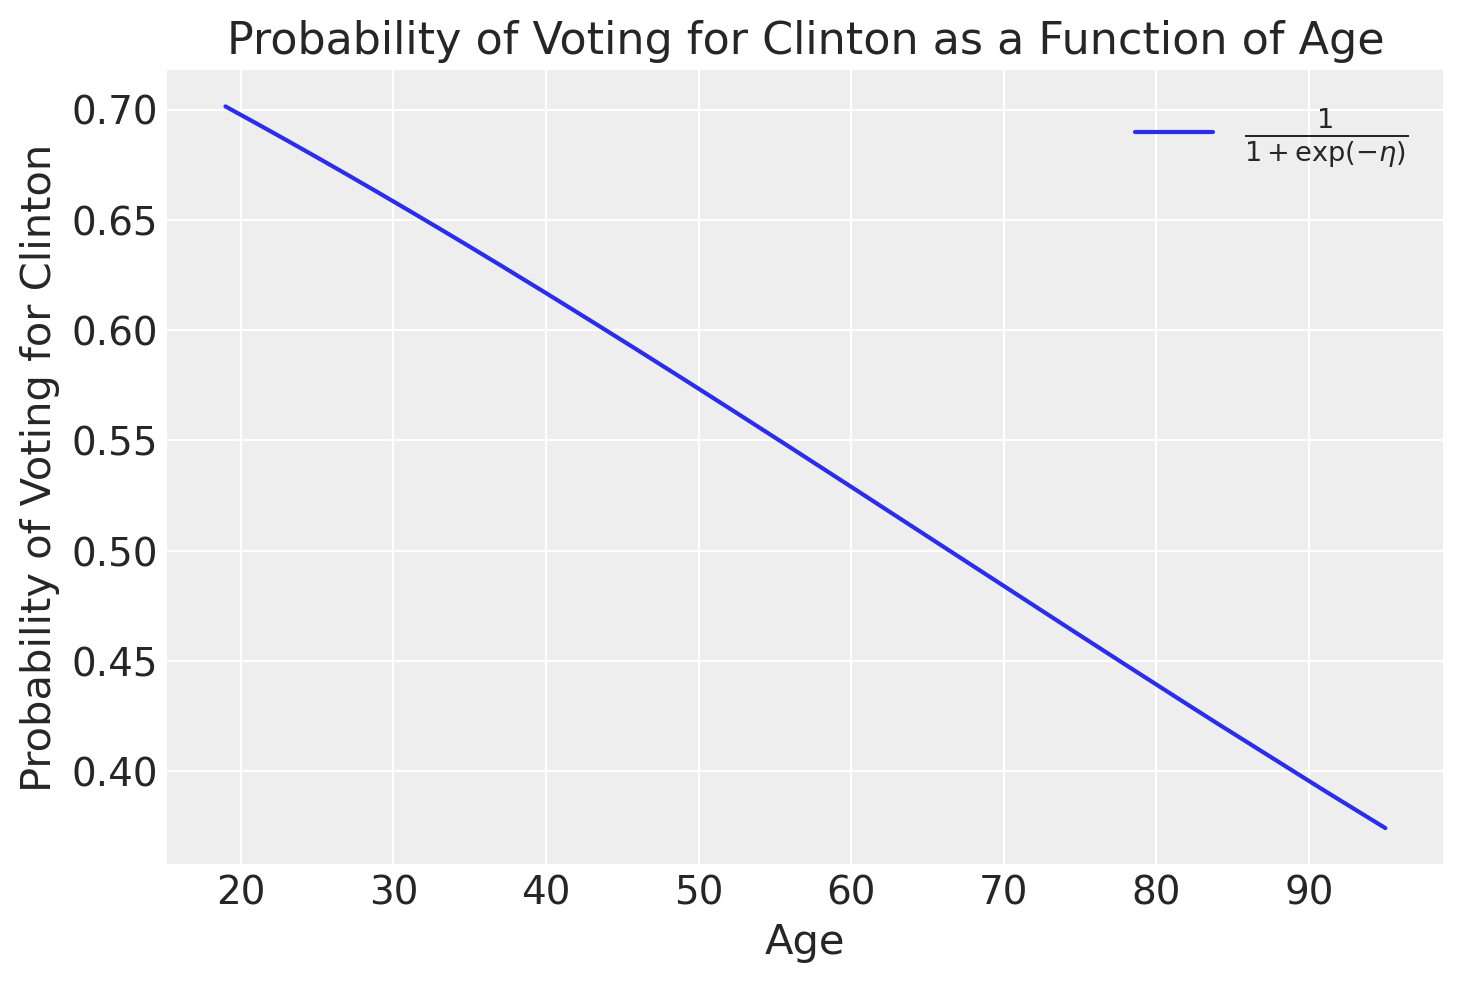

In [26]:
# Sort the age data first
sorted_age = np.sort(clinton_data["age"])

# Calculate eta using the sorted ages
eta_sorted = beta_0 + beta_1 * sorted_age

# Compute the sigmoid function
p_true_sorted = 1 / (1 + np.exp(-eta_sorted))

# Now, plot the sigmoid curve
plt.figure()
plt.plot(sorted_age, p_true_sorted, label=r"$\frac{1}{1 + \exp(-\eta)}$")
plt.xlabel("Age")
plt.ylabel(r"Probability of Voting for Clinton")  
plt.title("Probability of Voting for Clinton as a Function of Age")
plt.legend()
plt.show()

## Accuratezza delle classificazioni a posteriori

Esaminiamo ora la precisione delle nostre classificazioni posteriori. Nell'ambito della regressione, quando affrontiamo una variabile quantitativa  $Y$, abbiamo risposto a questa domanda analizzando la tipica differenza tra $Y$ e le sue previsioni posteriori. Tuttavia, nel contesto della classificazione con una variabile $Y$ categorica, le nostre classificazioni posteriori binarie di $Y$ possono essere corrette oppure errate. Pertanto, possiamo calcolare un indicatore globale di precisione.

Per procedere con il calcolo, il primo passo è determinare la probabilità a posteriori $P(Y = 1 | X)$, ovvero la probabilità che ciascuna osservazione rappresenti un voto per Clinton, per ogni singola osservazione.

Calcoliamo le probabilità predette dai coefficienti a posteriori del modello:

In [27]:
clinton_model.predict(clinton_fitted)

Le probabilità a posteriori possono essere estratte dall'oggetto `clinton_model` nel modo seguente.

In [28]:
print(clinton_fitted.posterior["vote_mean"])

<xarray.DataArray 'vote_mean' (chain: 4, draw: 1000, vote_obs: 373)>
array([[[0.54214313, 0.51602204, 0.47236266, ..., 0.51893134,
         0.59074563, 0.59074563],
        [0.53608905, 0.48709522, 0.40644185, ..., 0.49254397,
         0.62604339, 0.62604339],
        [0.60464957, 0.56663778, 0.50173235, ..., 0.570909  ,
         0.67281009, 0.67281009],
        ...,
        [0.56561157, 0.51507819, 0.43068312, ..., 0.52072747,
         0.65669871, 0.65669871],
        [0.5772925 , 0.56290163, 0.53869163, ..., 0.56450631,
         0.60410238, 0.60410238],
        [0.57660653, 0.53064743, 0.45327489, ..., 0.53579441,
         0.65935202, 0.65935202]],

       [[0.53549011, 0.49841217, 0.43685492, ..., 0.50253856,
         0.60415204, 0.60415204],
        [0.53549011, 0.49841217, 0.43685492, ..., 0.50253856,
         0.60415204, 0.60415204],
        [0.56361553, 0.52320368, 0.45543591, ..., 0.52771878,
         0.63730259, 0.63730259],
...
        [0.52476567, 0.47556455, 0.39505985, ...

Otteniamo così un array multidimensionale di dimensioni avente le seguenti dimensioni: chain: 4, draw: 1000, vote_obs: 373. Vogliamo la media a posteriori per ciascuna osservazione, ovvero vogliamo ridurre l'array precedente ad un vettore di 373 elementi. A questo fine possiamo procedere come indicato di seguito.

In [29]:
probs_array = clinton_fitted.posterior["vote_mean"]
average_posterior_values = probs_array.mean(dim=("chain", "draw"))
clinton_data["probs"] = average_posterior_values.values
clinton_data.head()

,vote,age,party_id,probs
0,clinton,56,democrat,0.548843
1,trump,65,republican,0.508959
2,clinton,80,democrat,0.442959
3,trump,38,republican,0.626106
4,trump,60,republican,0.531153


Creaiamo la variabile `predicted` che assume il valore 1 se la probabilità di un'osservazione è maggiore di 0.5 e 0 altrimenti.

In [30]:
clinton_data["predicted"] = (clinton_data["probs"] > 0.5).astype(int);

Classifichiamo le osservazioni ricodificando il voto "clinton" con 1 e 0 altrimenti.

In [31]:
clinton_data["actual"] = (clinton_data["vote"] == "clinton").astype(int)

Creiamo una matrice di confusione.

In [32]:
confusion = confusion_matrix(clinton_data["actual"], clinton_data["predicted"])
print(confusion)

[[ 28 130]
 [ 27 188]]


### Sensibilità, specificità e accuratezza complessiva del modello

Consideriamo $ Y $ come un insieme di $ n $ etichette binarie vere per i dati osservati e $ \hat{Y} $ come il set di etichette previste dal modello di classificazione. Possiamo utilizzare una matrice di confusione per riassumere la performance del modello confrontando le etichette vere con quelle predette. In questa matrice, la somma $ a + b + c + d $ è uguale al numero totale $ n $ di osservazioni.

- $ a $: Veri Negativi (TN) - Entrambe le etichette, reale e prevista, sono 0.
- $ b $: Falsi Positivi (FP) - L'etichetta reale è 0, mentre l'etichetta prevista è 1.
- $ c $: Falsi Negativi (FN) - L'etichetta reale è 1, mentre l'etichetta prevista è 0.
- $ d $: Veri Positivi (TP) - Entrambe le etichette, reale e prevista, sono 1.

|           | $ \hat{Y} = 0 $  | $ \hat{Y} = 1 $  |
|-----------|--------------------|--------------------|
| $ Y = 0 $| $ a $ (TN)       | $ b $ (FP)       |
| $ Y = 1 $| $ c $ (FN)       | $ d $ (TP)       |

L'**accuratezza complessiva** fornisce una misura della proporzione di etichette vere che il modello è riuscito a classificare correttamente:

$$
\text{accuratezza complessiva} = \frac{a + d}{a + b + c + d}
$$

**Sensibilità** e **specificità** sono altre due metriche importanti:

- La **sensibilità** (o tasso di veri positivi) rappresenta la proporzione di osservazioni positive $ Y = 1 $ che sono state correttamente identificate dal modello:

$$
\text{sensibilità} = \frac{d}{c + d}
$$

- La **specificità** (o tasso di veri negativi) rappresenta la proporzione di osservazioni negative $ Y = 0 $ che sono state correttamente identificate dal modello:

$$
\text{specificità} = \frac{a}{a + b}
$$

Queste metriche forniscono una visione completa delle performance del modello di classificazione.

Per i dati presenti abbiamo un'accuratezza complessiva di

In [33]:
(33 + 184) / (33 + 125 + 31 + 184)

0.5817694369973191

Abbiamo una sensibilità di

In [34]:
184/ (31+184)

0.8558139534883721

e una specificità di

In [35]:
33 / (33+125)

0.2088607594936709

I risultati indicano che il modello ha una capacità predittiva molto limitata, soprattutto se consideriamo la sua specificità. È evidente che è stato troppo ambizioso tentare di predire le intenzioni di voto basandosi unicamente sull'età. Questo tutorial rappresenta una versione semplificata dell'esempio discusso nel sito di Bambi, dove, oltre all'età, viene utilizzata anche l'appartenenza a un partito politico come predittore. In quel contesto, è chiaro che l'intenzione di voto può essere prevista con una precisione maggiore. Nell'esempio attuale, a fini didattici, abbiamo volutamente semplificato il modello per avere un unico predittore.

## Commenti e considerazioni finali

In questo capitolo, abbiamo esplorato il modello di regressione logistica, una tecnica statistica utilizzata per analizzare le relazioni tra variabili binarie e variabili indipendenti, sia continue che categoriche. Abbiamo spiegato come il modello di regressione logistica impieghi il logit delle probabilità per modellare il legame tra le variabili di risultato e i predittori. La funzione logit trasforma l'intervallo di probabilità da 0 a 1 in un intervallo da meno infinito a più infinito, rendendo possibile l'utilizzo di un modello di regressione lineare nel caso di variabili dipendenti dicotomiche.

In aggiunta, abbiamo illustrato come interpretare i coefficienti nel contesto del modello di regressione logistica. Quando il modello coinvolge una singola variabile indipendente, la rappresentazione grafica delle probabilità attese si rivela uno strumento di grande valore per ottenere una comprensione più accurata dei risultati.

Infine, abbiamo introdotto l'approccio bayesiano per ottenere stime a posteriori dei parametri. Questo approccio ci permette di ottenere una visione più completa delle incertezze legate alle stime dei coefficienti. Attraverso l'aggiornamento bayesiano, siamo in grado di calcolare intervalli di credibilità in base al grado di certezza soggettiva desiderato, offrendo così un ulteriore livello di informazione e interpretazione all'analisi.

## Watermark

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Aug 16 2023

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.14.0

matplotlib: 3.7.2
bambi     : 0.12.0
pandas    : 2.0.3
numpy     : 1.25.2
arviz     : 0.16.1

Watermark: 2.4.3

